# "Learning for Gold"
> "Machine learning with multiple targets"

- toc: true
- badges: true
- image: images/int2/int2-gold.jpg
- comments: true 
- author: Jordan Wilheim
- categories: [machine learning, python, eda, cleaning, multi-target, regression]

## Introduction

Let's say you've been hired by a gold extraction company. 

They're interested in developing a model that will predict the recovery of gold in their gold extraction process. We will explore the dataset, determine an appropriate error metric, and find a model that minimizes this error. 

![](nbimgs/gold_refine_process.jpg)

In [43]:
# collapse
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

sns.set()

from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_validate

STATE = 10

In [44]:
model_path = Path("../models")
file_paths = [
    Path("../datasets") / ("gold_recovery_" + name + ".csv")
    for name in ["train", "test", "full"]
]
train, X_test, full = (pd.read_csv(f, index_col='date') for f in file_paths)


## Exploratory Data Analysis 

The following transform allows us to separate categories into individual state, statetype and mineral to better understand how share value changes in each step.

### Filtration process

In [45]:
train.columns[train.columns.str.endswith("au")]

Index(['final.output.concentrate_au', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_au', 'rougher.input.feed_au',
       'rougher.output.concentrate_au', 'rougher.output.tail_au',
       'secondary_cleaner.output.tail_au'],
      dtype='object')

### Target Leakage 

We need to make sure we don't include features that will not be available at prediction time.  

We can determine which features these are by comparing our training set with the given test set that omits certain features. 

In [46]:
# Examining the difference in columns between the training and testing set.
features = X_test.columns
train.loc[:, sorted(set(train.columns).difference(set(features)))].info()

<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_au                         16789 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_au                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                            

![](nbimgs/gold_ext_detailed.jpg)

In [47]:
test = full.loc[X_test.index]
print(f"Training set shape: {train.shape}, Testing set shape: {test.shape}")

Training set shape: (16860, 86), Testing set shape: (5856, 86)


### Target Variable Creation

In order to predict recovery, recovery must be generated as a target variable from rougher input, output and tails.

![](nbimgs/Recover_calc.jpg)

Where:
- C - share of gold in concentrate right after flotation - `rougher.output.concentrate_au`
- F - share of gold in the feed before flotation - `rougher.input.feed_au`
- T - share of gold in rougher tails right after flotation - `rougher.output.tail_au`

We're going to calculate gold recovery from the first and second process using the following function.

I've added some filtration steps if any value is zero or negative.

In [48]:
def calc_recovery(C, F, T):
    rec = ((C * (F - T)) / (F * (C - T))) * 100
    return rec

In [49]:
datasets = [train, test]

types = {
    "recovery_first": [
        "rougher.output.concentrate_au",
        "rougher.input.feed_au",
        "rougher.output.tail_au",
    ]
}

for d in datasets:
    for name, cols in types.items():
        d[name] = calc_recovery(*[d[t] for t in cols])
        

### Missing and Unusual Values in Targets

Strategy:

    - Drop NA values if contained in either target variables.
    - Drop values that are between 0 and 100 in the training and testing set.
    - EDA shows that values in the range of 40 - 98 % recovery helps reduce outlying values. 
        - These will only be performed on the training set.



In [59]:
def clean_target(df, targets, lower=0, upper=100):
    
    clean_na = ~df[targets].isna().any(axis=1)
    
    clean_outrange = df[targets].apply(lambda x: x.between(lower, upper, inclusive=False)).all(axis=1)
    
    return df.loc[clean_na & clean_outrange]

In [62]:
targets = ['recovery_first', 'final.output.recovery']
train, test = [clean_target(_, targets) for _ in [train, test]]

In [63]:
X_train, y_train = (
    train[features],
    train[["recovery_first", "final.output.recovery"]],
)
X_test, y_test = (
    test[features],
    test[["recovery_first", "final.output.recovery"]],
)

There's a long tail distribtion, though I'm uncertain if these values are a true phenomenon. 

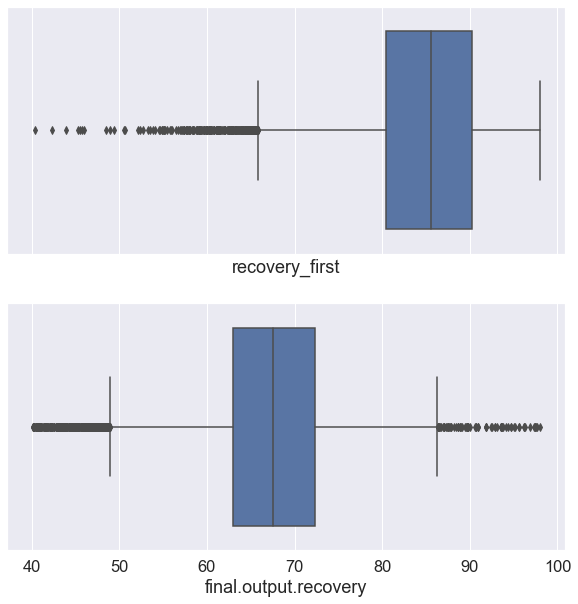

In [68]:
# collapse
with sns.plotting_context('notebook', font_scale=1.5):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=[10,10])
    sns.boxplot(train["recovery_first"], ax=axes[0])
    sns.boxplot(train["final.output.recovery"], ax=axes[1])


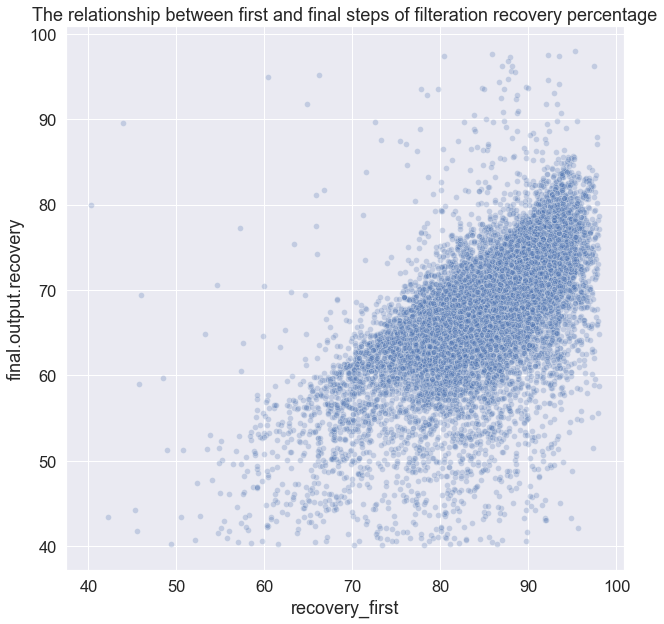

In [69]:
#collapse
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=[10,10])
    sns.scatterplot(data=train, x='recovery_first', y='final.output.recovery', alpha=0.25, ax=ax)
    ax.set(title='The relationship between first and final steps of filteration recovery percentage')

Here we can observe how the process creating a higher share of gold as it is processed, while the other minerals have a higher share in the tails. 

There also seems to be some long tails with the output.concentrate of au.

The final stage is much more effective at increasing the share of gold in our solution.

Because the second process is so much more effective, We can give more weight to the model that can give us a stronger prediction of a high yield at the final stage.

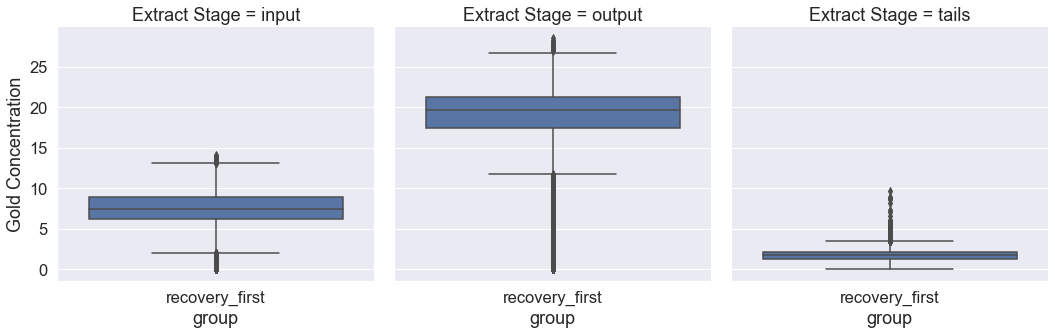

In [54]:
# collapse

dfs = []
for group, col_names in types.items():
    vis_df = pd.melt(
        train[col_names], var_name="Extract Stage", value_name="Gold Concentration"
    )
    vis_df["group"] = group
    dfs.append(vis_df)
vis_df = pd.concat(dfs)

vis_df["Extract Stage"] = (
    vis_df["Extract Stage"]
    .str.replace("final.output.concentrate_au", "output")
    .str.replace("rougher.output.tail_au", "tails")
    .str.replace("final.output.tail_au", "tails")
    .str.replace("rougher.input.feed_au", "input")
)

vis_df.loc[
    (vis_df["group"] == "recovery_final")
    & (vis_df["Extract Stage"] == "rougher.output.concentrate_au"),
    "Extract Stage",
] = (
    "input"
)
vis_df["Extract Stage"] = vis_df["Extract Stage"].str.replace(
    "rougher.output.concentrate_au", "output"
)

order = ["input", "output", "tails"]

with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.catplot(
        x="group",
        y="Gold Concentration",
        data=vis_df,
        col="Extract Stage",
        kind="box",
        col_order=order,
    )


We can now compare metal shares throughout the purification process. 

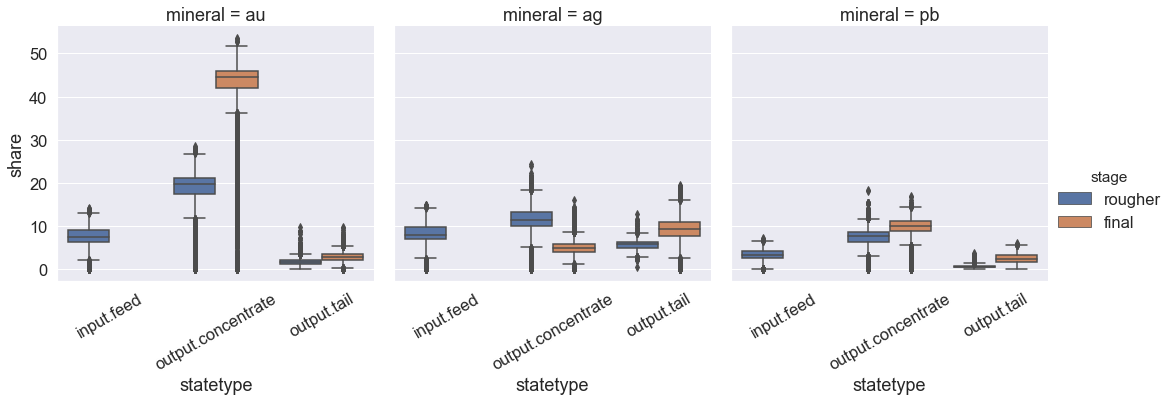

In [55]:
#collapse

cats = [
    "rougher.input.feed",
    "rougher.output.concentrate",
    "rougher.output.tail",
    "final.output.concentrate",
    "final.output.tail",
]

ele_df = train.loc[:, train.columns.str.match("|".join(cats))].melt(
    var_name="name", value_name="share"
)
pattern = r"(?P<stage>\w+)\.(?P<statetype>\w+\.\w+)_(?P<mineral>\w\w)"
ele_df = ele_df.join(ele_df["name"].str.extract(pattern)).drop("name", axis=1)

with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.catplot(
        kind="box",
        hue="stage",
        y="share",
        data=ele_df,
        col_order=["au", "ag", "pb"],
        x="statetype",
        col="mineral",
        hue_order=["rougher", "final"],
        order=["input.feed", "output.concentrate", "output.tail"],
    )
    g.set_xticklabels(rotation=30)
    

In [56]:
# collapse
ele_df.loc[ele_df["mineral"] == "au"].groupby(
    ["statetype", "stage", "mineral"]
).describe()

share                                  \
                                      count       mean        std       min   
statetype          stage   mineral                                            
input.feed         rougher au       16777.0   7.170717   3.002113  0.000000   
output.concentrate final   au       16789.0  39.467217  13.917227  0.000000   
                   rougher au       16778.0  17.401541   6.921875  0.000000   
output.tail        final   au       16794.0   2.687512   1.272757  0.000000   
                   rougher au       14611.0   1.763930   0.731518  0.020676   

                                                                                
                                          25%        50%        75%        max  
statetype          stage   mineral                                              
input.feed         rougher au        6.203083   7.443530   8.965193  14.093363  
output.concentrate final   au       42.055722  44.498874  45.976222  53.611374  
                   rougher au       17.443663  19.644663  21.224486  28.522811  
output.tail        final   au        2.172953   2.781132   3.416936   9.789625  
                   rougher au        1.311610   1.747907   2.190839   9.688980

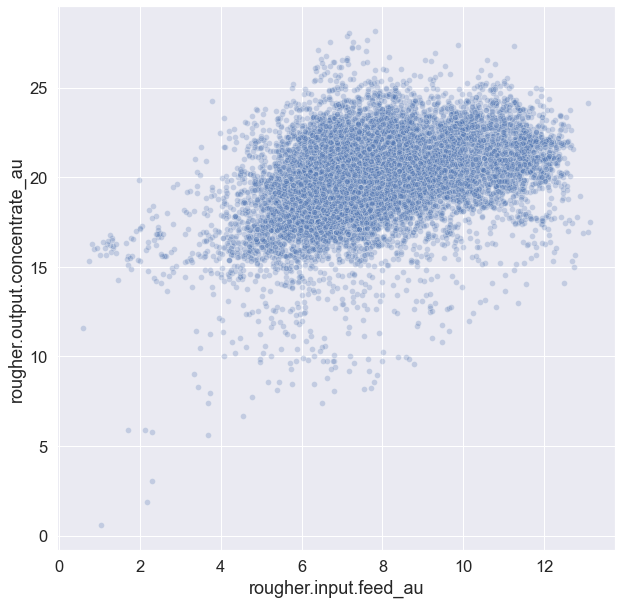

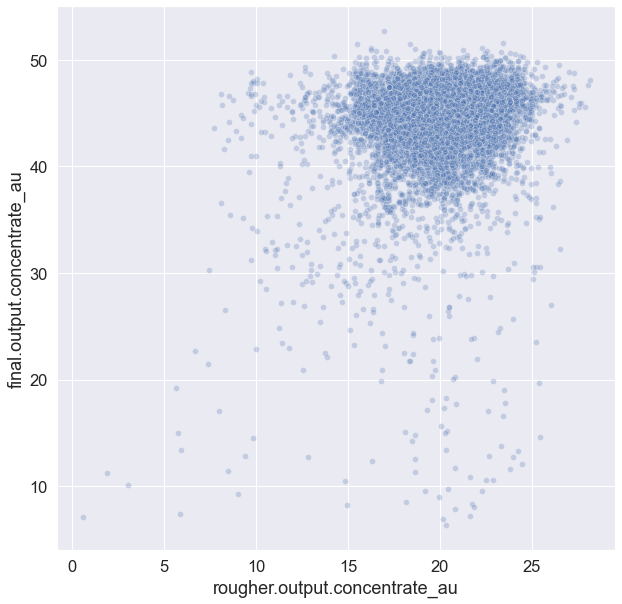

In [70]:
#collapse
scatter_dat = train.loc[:, train.columns.str.match("|".join(cats))]
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=[10,10])
    g = sns.scatterplot(data=scatter_dat, x="rougher.input.feed_au", y="rougher.output.concentrate_au", ax=ax, alpha=0.25)
    plt.show()
    
    fig, ax = plt.subplots(figsize=[10,10])
    g = sns.scatterplot(data=scatter_dat, x="rougher.output.concentrate_au", y="final.output.concentrate_au", ax=ax, alpha=0.25)
    plt.show()

In order to determine if the training set is very representative, we can compare our features between training and testing sets. Here's and example of how we can do that.  

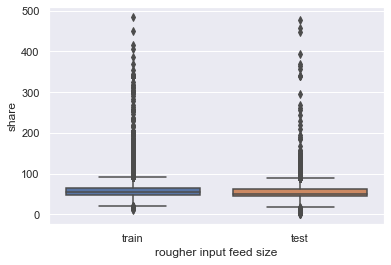

In [58]:
#collapse
comp_feed = pd.concat(
    [train["rougher.input.feed_size"], test["rougher.input.feed_size"]], axis=1
)
comp_feed.columns = ["train", "test"]
comp_feed = pd.melt(comp_feed, var_name="rougher input feed size", value_name="share")
sns.boxplot(data=comp_feed, x="rougher input feed size", y="share")
plt.show()

## Machine Learning

![](nbimgs/smape_target_combine.jpg)

### Preprocessing

Based on exploring the dataset, I'm going to trim target training values to be in between 40 and 98 % recovery. 

Ideally this will yield a higher test score. 

In [60]:
targets = ['recovery_first', 'final.output.recovery']
train_c = clean_target(train, targets, lower=40, upper=98)
test_c = clean_target(test, targets)



print(f"After filtering, we are retaining {(train_c.shape[0]/train.shape[0]):.2%} of the training data")
print(f"After filtering, we are retaining {(test_c.shape[0]/test.shape[0]):.2%} of the testing data")

train = train_c
test = test_c

train[targets].describe()

After filtering, we are retaining 79.64% of the training data
After filtering, we are retaining 87.74% of the testing data


,recovery_first,final.output.recovery
count,13428.000000,13428.000000
mean,84.676688,67.117387
std,7.369024,7.762972
min,40.346710,40.092124
25%,80.473341,62.948731
50%,85.554797,67.507883
75%,90.257993,72.299998
max,97.983095,97.987428


### Scoring

![](nbimgs/smape_target_combine.jpg)

In [24]:
def calc_smape(y: np.array, y_pred: np.array) -> float:
    """Symmetric Mean Absolute Percentage Error"""
    smape_s = (
        np.mean(
            (
                np.abs(y_pred - y)
                / ((np.abs(y) + np.abs(y_pred)) / 2)
            )
        )
        * 100
    )

    return smape_s

def smape_score(y: np.array, y_pred: np.array) -> float:
    """Combine the """
    smape_r = calc_smape(y[:, 0], y_pred[:, 0])
    smape_f = calc_smape(y[:, 1], y_pred[:, 1])
    final_score = smape_r * 0.25 + smape_f * 0.75
    return final_score

Here's what our target and training data look like. 

In [73]:
y_train.head()

,recovery_first,final.output.recovery
date,,
2016-01-15 00:00:00,87.107763,70.541216
2016-01-15 01:00:00,86.843261,69.266198
2016-01-15 02:00:00,86.842308,68.116445
2016-01-15 03:00:00,87.226430,68.347543
2016-01-15 04:00:00,86.688794,66.927016


In [25]:
X_train.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Now that we have a preprocessing plan, lets experiment with two algorithms. 
    
    
    - A stochastic gradient decent algorithm with a grid search of reasonable hyperparameters.
    - A random forest with 200 estimators.

In [26]:
prep = make_pipeline(SimpleImputer(), StandardScaler())

Here's what the grid search looks like. Luckly, SGD can be very quick and we can rapidly search through our parameters.

In [27]:
#collapse

lin = make_pipeline(prep, MultiOutputRegressor(SGDRegressor(random_state=STATE)))

lhparams = {
    "multioutputregressor__estimator__alpha": 10.0 ** -np.arange(1, 4),
    "multioutputregressor__estimator__penalty": ["l2", "l1", "elasticnet"],
    "multioutputregressor__estimator__loss": [
        "huber",
        "squared_loss",
        "epsilon_insensitive",
    ],
    "pipeline__simpleimputer__strategy": ["mean", "median"],
}

try:
    lin_search = load(model_path / "lin_search.joblib")
except:
    lin_search = GridSearchCV(
        lin,
        lhparams,
        scoring=make_scorer(smape_score, greater_is_better=False),
        cv=5,
        n_jobs=-1,
    )
    lin_search.fit(X_train, y_train.values)
    dump(lin_search, model_path / "lin_search.joblib")

print(f"Our best linear model produced a symmetric mean absolute error of {-lin_search.best_score_:.2f} percent on the mean validation score")

Our best linear model produced a symmetric mean absolute error of 7.63 percent on the mean validation score


We can see the params from our search as well:

In [28]:
#collapse
lin_search.best_params_

{'multioutputregressor__estimator__alpha': 0.01,
 'multioutputregressor__estimator__loss': 'huber',
 'multioutputregressor__estimator__penalty': 'l2',
 'pipeline__simpleimputer__strategy': 'median'}

To see if it's worth experimenting with a random forest algorithm, let's try using one and seeing how well it compares to our best linear model. 

In [30]:
rf_pipe = make_pipeline(
    SimpleImputer(), RandomForestRegressor(n_estimators=200, random_state=STATE)
)
rf_cv = cross_validate(
    rf_pipe,
    X=X_train,
    y=y_train.values,
    cv=5,
    scoring=make_scorer(smape_score, greater_is_better=False),
    n_jobs=-1,
)

The random forest regressor isn't producing very good validation scores. Let's stick with our best linear model. 

In [31]:
rf_cv

{'fit_time': array([532.29898024, 536.56886029, 503.935009  , 519.00876713,
        231.90553808]),
 'score_time': array([0.36240578, 0.22816491, 0.31431985, 0.59734297, 0.15358281]),
 'test_score': array([-8.00994812, -7.41541227, -6.12781725, -8.00751447, -9.59524186])}

We can also determine a baseline to see how much more effective our best predictor is. 

In [32]:
#collapse
dummy_score = DummyRegressor(strategy='median')
dummy_score.fit(X=X_train, y=y_train.values)
dum_pred = dummy_score.predict(X_test)

print(f"""Our baseline using the median score of our training data
yields a SMAPE of: {smape_score(y=y_test.values, y_pred=dum_pred):.2f}% on the test dataset""")

Our baseline using the median score of our training data
yields a SMAPE of: 7.28% on the test dataset


## Conclusion

In [33]:
#collapse
test_score = lin_search.score(X_test, y_test.values)
print(f"""Our best linear model produced a symmetric mean absolute error of:
      {-test_score:.2f}% on our testing dataset""")

Our best linear model produced a symmetric mean absolute error of:
      6.69% on our testing dataset


We're able to get a slight improvement on recovery using our linear model, but not by much. 

If we're not satisfied with this score, it may be worth experimenting with more advanced imputation techniques, more complex models, and feature engineering. 